# ISMB 2022 poster - promor: An integrative approach for proteomics data analysis and modeling


#### Chathurani Ranathunge

This Jupyter Notebook provides code for the data analysis and plots shown on our ISMB 2022 poster.




In [ ]:
library(promor)
library(ggplot2)
library(viridis)
library(VennDiagram) 

# 1. Benchmarking
## 1.1 promor results

In [ ]:
#Create a raw_df object with proteinGroups.txt and exp_design file
raw_df <- create_df(prot_groups = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD000279_proteinGroups.txt",
                    exp_design = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD000279_expDesign.txt",
                    uniq_pep = 1)

#Filter out proteins with higher than 34% missing data in each one group (in other words - requires 67% valid data in at least one group to retain the protein)
raw_df_filt <- filterbygroup_na(raw_df, set_na = 0.34, filter_condition = "each")

#Impute missing data
imp_df <- impute_na(raw_df_filt)

#Non-normalized to compare with LFQ-Analyst
norm_df <- normalize_data(imp_df, method = "none")

#Find DE proteins
fit_df <- find_dep(norm_df)

#Save results from all 1446 DE proteins
fit_df <- find_dep(norm_df, n_top = 1446, save_tophits = TRUE, save_output = TRUE)

#Upload the TopHits
de_promor <- read.csv("./TopHits.txt", sep = "\t")

#Add a Protein.IDs column to promor results by extracting the first protein from majority_protein_ids
de_promor$Protein.IDs <- sapply(strsplit(as.character(de_promor$majority_protein_id),';'), "[", 1)

#Extract only those columns we need from de_promor
de_promor <- de_promor[,c("Protein.IDs","P.Value","logFC" )]

#Add a new column with the method information
de_promor$method <- "promor"

#Let's give both data frames similar column names
colnames(de_promor) <- c("protein", "p_value", "log_fc", "method")

#Make a list object to build a venn diagram 
de_promor_prot <- de_promor$protein

## 1.2 LFQ-Analyst results 

**Input data**

proteinGroups.txt file: https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD000279_proteinGroups.txt
lfq-analyst experimental design file: https://raw.githubusercontent.com/caranathunge/promor_example_data/main/benchmarking/PXD000279_lfqanalyst_expdesign.txt

**Parameters used:**

Adjusted p-value cutoff = 0.05\
Log-2-fold change cutoff = 1\
Imputation type : MinProb method\
Type of FDR correction: Benjamini Hochberg method\

**Results**

LFQ-Analyst identified 1409 significantly differentially expressed proteins between H and L conditions.\
Complete results from the DE analysis were saved as: "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/benchmarking/PXD000279_lfqanalyst_results.csv"

In [ ]:
#Upload LFQ-Analyst results
lfq_analyst_results <- read.csv("https://raw.githubusercontent.com/caranathunge/promor_example_data/main/benchmarking/PXD000279_lfqanalyst_results.csv")

#Reduce the data frame to significant hits and limit the data frame to only those columns we need
de_lfq_analyst <- lfq_analyst_results[lfq_analyst_results$significant == 'TRUE',c("Protein.IDs",
                                                                                  "H_vs_L_p.val",
                                                                                  "H_vs_L_log2.fold.change")]

#Add a new column with the name of the method used
de_lfq_analyst$method <- "LFQ-Analyst"

#Let's give both data frames similar column names
colnames(de_lfq_analyst) <- c("protein", "p_value", "log_fc", "method")

#Make a list object to build a venn diagram 
de_lfq_analyst_prot <- de_lfq_analyst$protein

## 1.3 Compare results from the two packages

In [ ]:
#Make a plot
venn.diagram(list("promor" = de_promor_prot, "LFQ_Analyst" = de_lfq_analyst_prot), 
             fill = c("#17456B","#ACF0F2"), 
             alpha = c(0.5, 0.5), 
             resolution = 400,
             lwd = 5, 
             filename = "~/Desktop/venn_diagram.tiff",
             scaled = TRUE,
             ext.pos = 0,
             ext.percent = 0.5,
             fontface = "bold",
             ext.line.lwd = 3
            )


# 2. Quality Control & Visualization

## 2.1 Technical replicate correlation

In [ ]:
#Upload the data
raw_df1 <- create_df(prot_groups = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD001584_proteinGroups.txt",
                 exp_design = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD001584_expDesign.txt",
                 uniq_pep = 1,
                 tech_reps = TRUE)

#Make correlation plots
corr_plot(raw_df1, rep1 = 1, rep2 = 2, 
          file_type = "png", save = TRUE, 
          dpi = 300, text_size = 20, 
          n_row = 3, n_col = 2, 
          palette = "mako")

## 2.2 Missing data distribution - heatmap

226 proteins with higher than 50% NAs in each group removed.



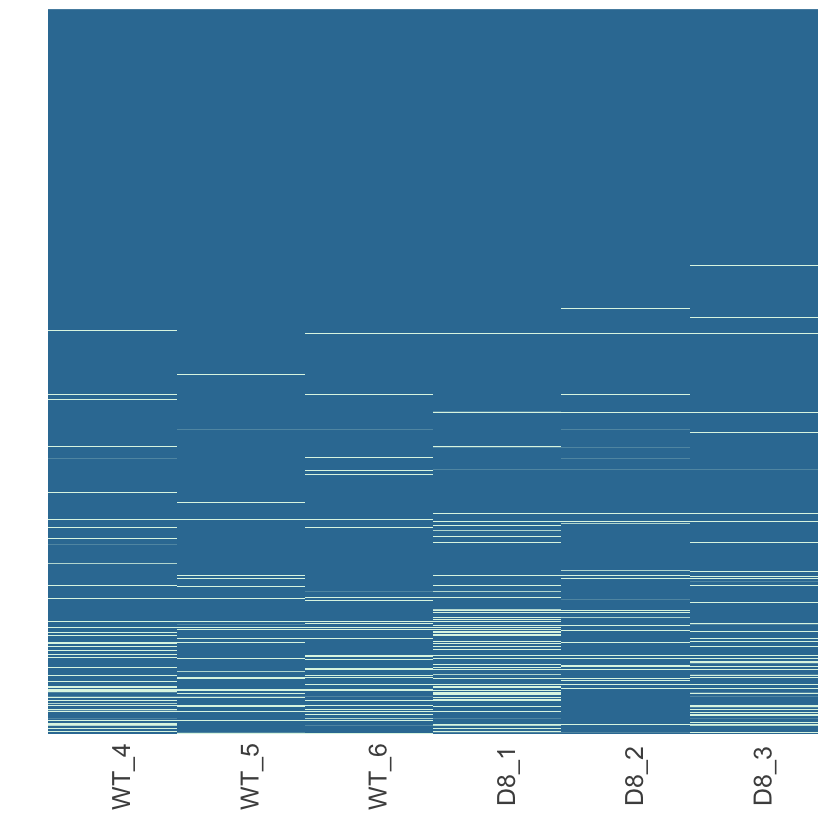

In [198]:
#Calculate average across tech reps
rawdf1_avg <- aver_techreps(raw_df1)

#Filter proteins by group level missing data
rawdf1_filt <- filterbygroup_na(rawdf1_avg, set_na = 0.50, filter_condition = "each")

#Make missing data heatmap
heatmap_na(rawdf1_filt, text_size = 15, reorder_y = TRUE,  save = TRUE, file_type = "png", dpi = 300, palette = "mako")

## 2.3 Missing data imputation - density plots

Warning message:
“Removed 289 rows containing non-finite values (stat_density).”
Warning message:
“Removed 289 rows containing non-finite values (stat_density).”


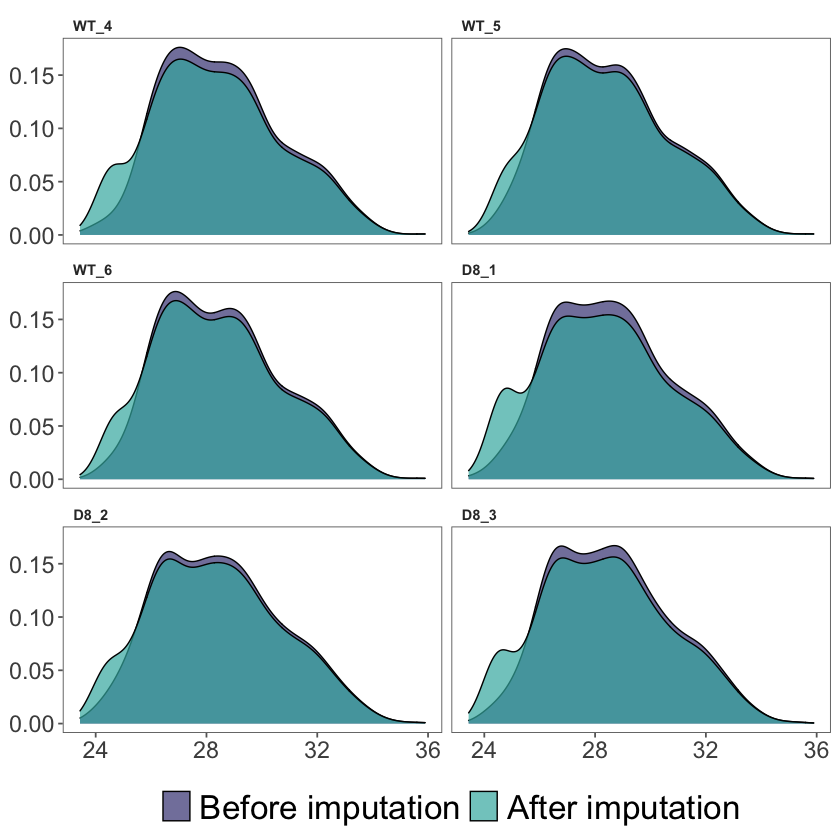

In [199]:
#Impute missing data using minDet method
imp_df1 <- impute_na(rawdf1_filt, method = "minDet")

#Visulaize missing data imputation
impute_plot(original = rawdf1_filt, imputed = imp_df1,
            global = FALSE,  n_col = 2, n_row = 3, 
            dpi = 300, save = TRUE, file_type = "png", 
            palette = "mako", text_size = 20)

## 2.4 Data normalization - density plots

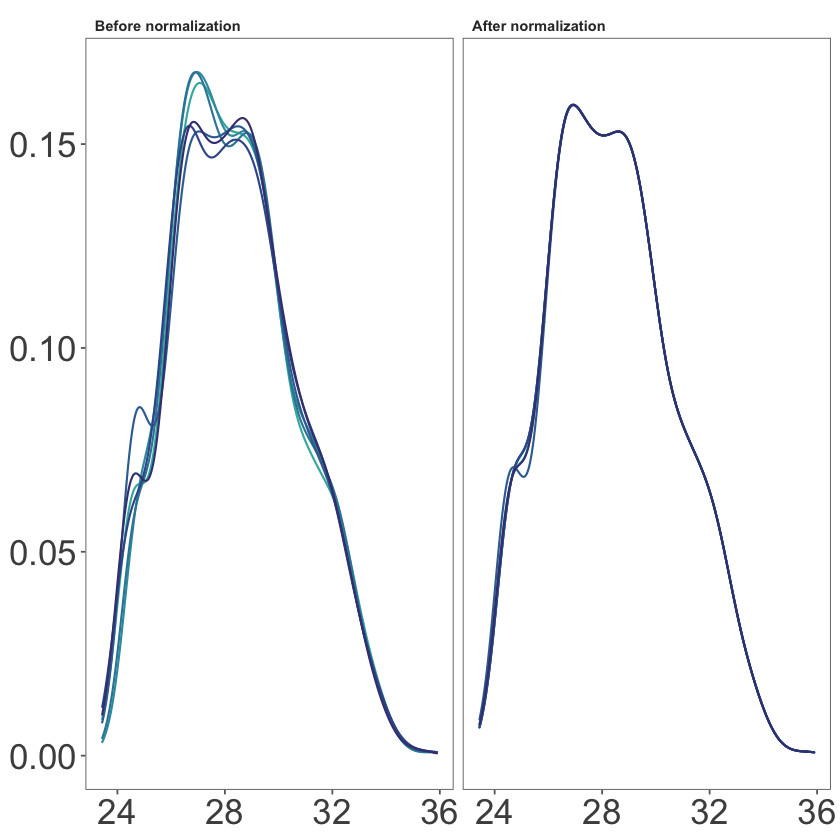

In [200]:
#Normalize the data set
norm_df1 <- normalize_data(imp_df1, method = "quantile")

#Make density plots to compare before and after
norm_plot(original = imp_df1, normalized = norm_df1, 
          type = "density", save = TRUE, dpi = 300,
          file_type = "png", palette = "mako", text_size = 30)

# 3. Differential expression analysis
## 3.1 Volcano plot
For visual impact, we used a different data set to create the volcano plot on the poster

0 empty rows removed.

0 empty columns removed.

80 proteins (rows) only identified by site removed.

65 reverse proteins (rows) removed.

1923 proteins identified by 2 or fewer unique peptides removed.

65 proteins with higher than 34% NAs in each group removed.

Warning message:
“3 very small variances detected, have been offset away from zero”
1210 siginificantly differentially expressed proteins found.



                                                majority_protein_id     logFC
1              P14618;P14618-2;P14618-3;E9PF79;H3BTN5;Q504U3;E7EUJ4  1.043522
2                                     O43390;O43390-2;Q2L7G6;E7ETM7  1.149471
4  P07355;P07355-2;H0YN42;H0YMD0;H0YMU9;H0YM50;A6NMY6;H0YKS4;B3KRQ1  1.266323
6                                              P04075;H3BQN4;H3BPS8  1.107394
7                                              B7Z4V2;P38646;F5H3L8  1.234165
13                                                           O00299  1.203887
14                                                           P0ADU2 -1.775298
15                                           P07900;P07900-2;Q86U12  1.057117
17                                                           P07913 -1.684242
18                                                           P00864 -1.159245
19                                                    P27824;B4E2T8  1.001329
22                                                           P0A

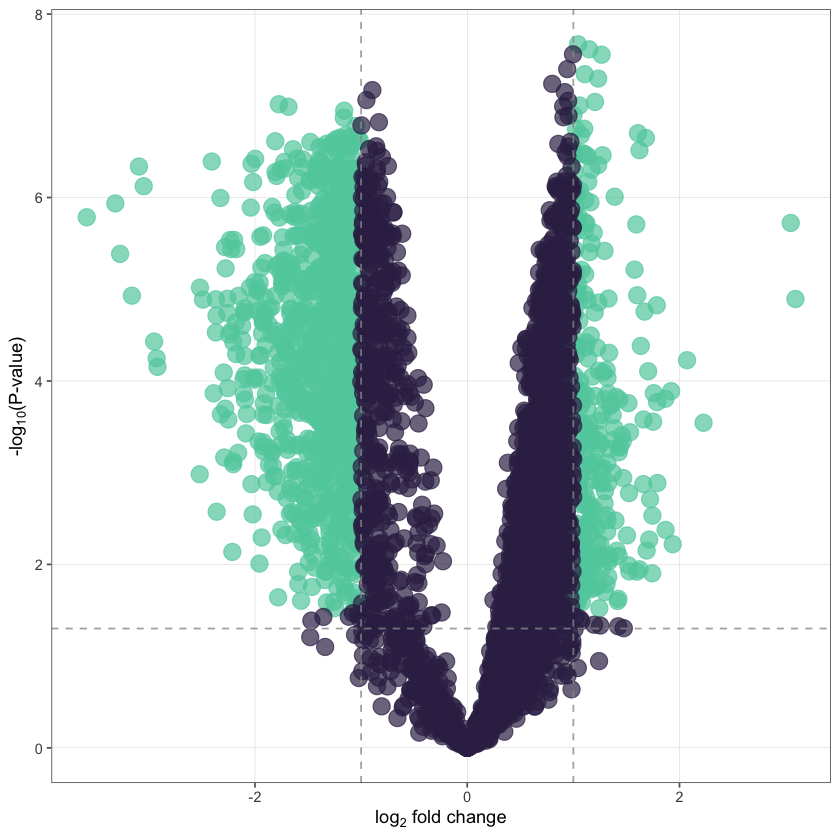

In [201]:
#Upload data set 2
raw_df2 <- create_df(prot_groups = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD000279_proteinGroups.txt",
                 exp_design = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD000279_expDesign.txt",
                 uniq_pep = 2)

#Filter by group level missing data
rawdf2_filt <- filterbygroup_na(raw_df2, set_na = 0.34, filter_condition = "each")

#Impute missing data
imp_df2 <- impute_na(rawdf2_filt, method = "kNN")

#Normalize data
norm_df2 <- normalize_data(imp_df2)

#Find DE proteins
fit_df2 <- find_dep(norm_df2)

#Make volcano plot
volcano_plot(fit_df2, save = TRUE, 
             file_name = "volcano_plot_ecoli", dpi = 300, 
             file_type = "png", palette = "mako", text_size = 15)

## 3.2 Heatmap - DE proteins
A third data set was used for the heatmap and the modeling plots

0 empty rows removed.

0 empty columns removed.

22 proteins (rows) only identified by site removed.

12 reverse proteins (rows) removed.

571 proteins identified by 2 or fewer unique peptides removed.

469 proteins with higher than 34% NAs in each group removed.

16 siginificantly differentially expressed proteins found.



       majority_protein_id     logFC  AveExpr         t      P.Value
2     sp|P25311|ZA2G_HUMAN  1.474846 26.42586  4.879131 1.959045e-05
3    sp|P02652|APOA2_HUMAN -1.360483 29.76704 -4.497065 6.360858e-05
5    sp|P02765|FETUA_HUMAN -1.080471 30.77639 -3.754601 5.838872e-04
6     sp|Q6UXB8|PI16_HUMAN -1.816389 20.64333 -3.486717 1.256858e-03
7     sp|P13796|PLSL_HUMAN  2.200759 21.39592  3.418044 1.524388e-03
9     sp|P22352|GPX3_HUMAN  1.437625 23.47722  3.318238 2.012219e-03
10    sp|Q16610|ECM1_HUMAN -1.058193 26.32939 -3.286499 2.196371e-03
11    sp|P00915|CAH1_HUMAN  1.598166 25.43823  3.259815 2.363518e-03
12    sp|P00746|CFAD_HUMAN -1.335111 24.80421 -3.216560 2.660437e-03
13    sp|P14780|MMP9_HUMAN  1.850215 20.92870  3.157387 3.124427e-03
14    sp|P02743|SAMP_HUMAN  2.884992 21.66151  3.086011 3.810908e-03
15   sp|P04083|ANXA1_HUMAN  1.946499 20.26602  3.060611 4.052248e-03
16    sp|P67936|TPM4_HUMAN -2.015280 24.85469 -3.013534 4.592443e-03
17    sp|P17936|IBP3_HUMAN -1.5655

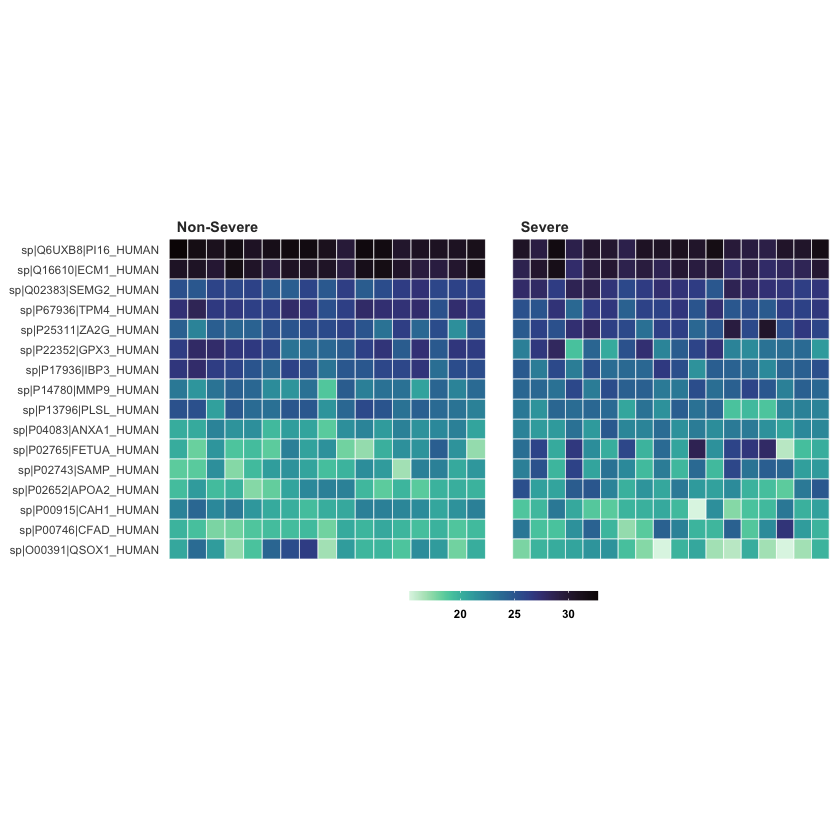

In [203]:
#Upload data set 3
raw_df3 <- create_df(prot_groups = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD022296_proteinGroups_subset.txt",
                  exp_design = "https://raw.githubusercontent.com/caranathunge/promor_example_data/main/PXD022296_expDesign_subset.txt",
                  uniq_pep = 2)

#Filter by group level missing data
rawdf3_filt <- filterbygroup_na(raw_df3, set_na = 0.34, filter_condition = "each")

#Impute missing data
imp_df3 <- impute_na(rawdf3_filt, method = "kNN")

#Normalize data
norm_df3 <- normalize_data(imp_df3)

#Find DE proteins
fit_df3 <- find_dep(norm_df3, cutoff = 0.1)

#Make a heatmap of top 20 DE proteins
heatmap_de(fit_df = fit_df3, norm_df = norm_df3, 
           n_top = 20, cutoff = 0.1, 
           save = TRUE, dpi = 300, file_name = "heatmap_covid",
           file_type = "png", palette = "mako")

# 4. Feature selection
## 4.1 Feature plots

Total number of differentially expressed proteins (5) is less than n_top.

None of the proteins show high pair-wise correlation.



No highly correlated poteins to be removed.

Using condition as id variables



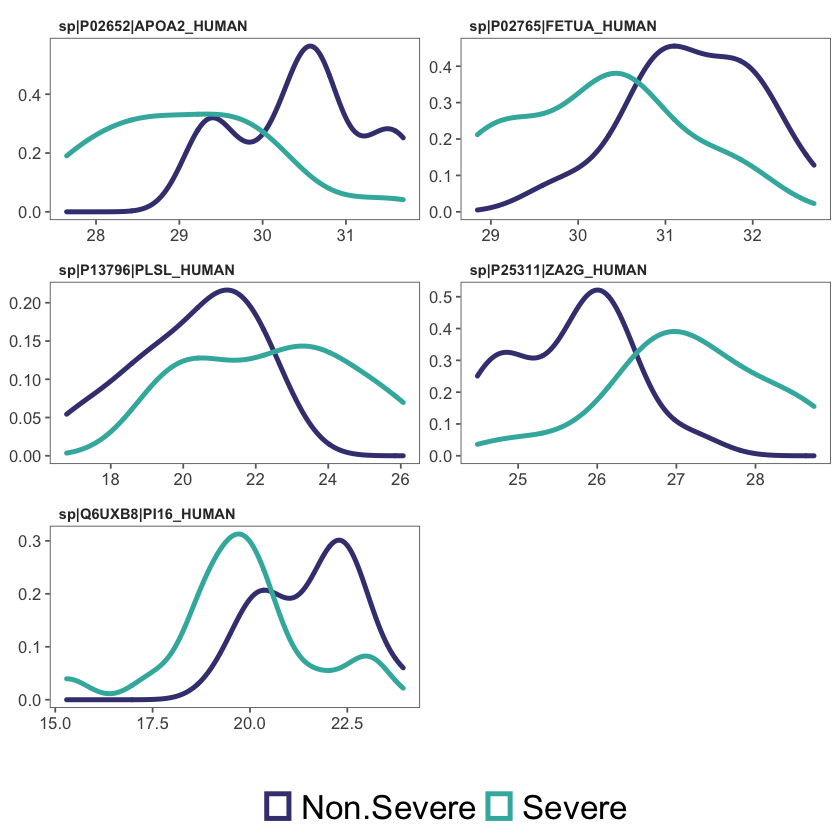

In [206]:
#create a model_df object
model_df3 <- pre_process(fit_df = fit_df3, norm_df = norm_df3, sig_cutoff = 0.06)

#Make feature plots
feature_plot(model_df3,  save = TRUE,  
             type = "density", dpi = 300, file_name = "feature_covid_density", 
             file_type = "png",  n_col = 2, n_row = 3,
             plot_width = 3, plot_height = 15, 
             palette = "mako", text_size = 20)


## 4.2 Variable importance plots


Running svmRadial...


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Running rf...


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Running glm...


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitte

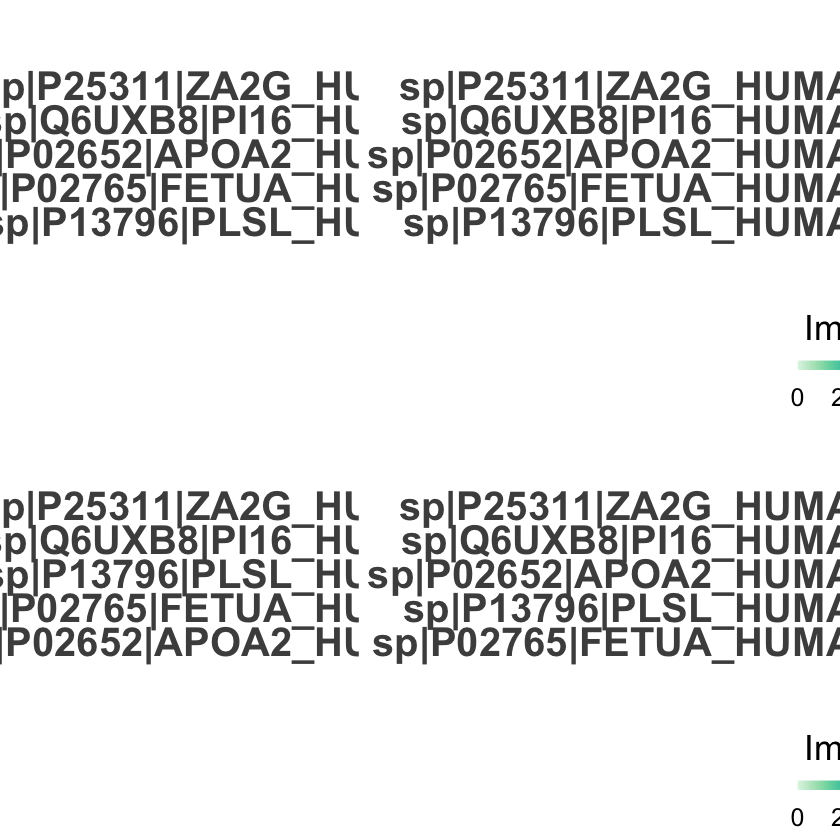

In [209]:
#split the model_df object into training and test data
split_df3 <- split_data(model_df3, train_size = 0.5)

#train models on training data
model_list <- train_models(split_df3, resample_method = "repeatedcv")

#Make variable importance plots
varimp_plot(model_list, save = TRUE,  
            plot_width = 28, plot_height = 20, 
            n_col = 2, n_row = 2 ,
            text_size = 30, dpi = 300, file_type = "png", 
            file_name = "varimp_covid", palette = "mako")

# 5. Model building & Evaluation
## 5.1 Performance plots

Using Resample as id variables

Warning message:
“Removed 15 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 15 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing missing values (geom_segment).”
Warning message:
“Removed 4 rows containing missing values (geom_segment).”
Warning message:
“Removed 15 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 15 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing missing values (geom_segment).”
Warning message:
“Removed 4 rows containing missing values (geom_segment).”


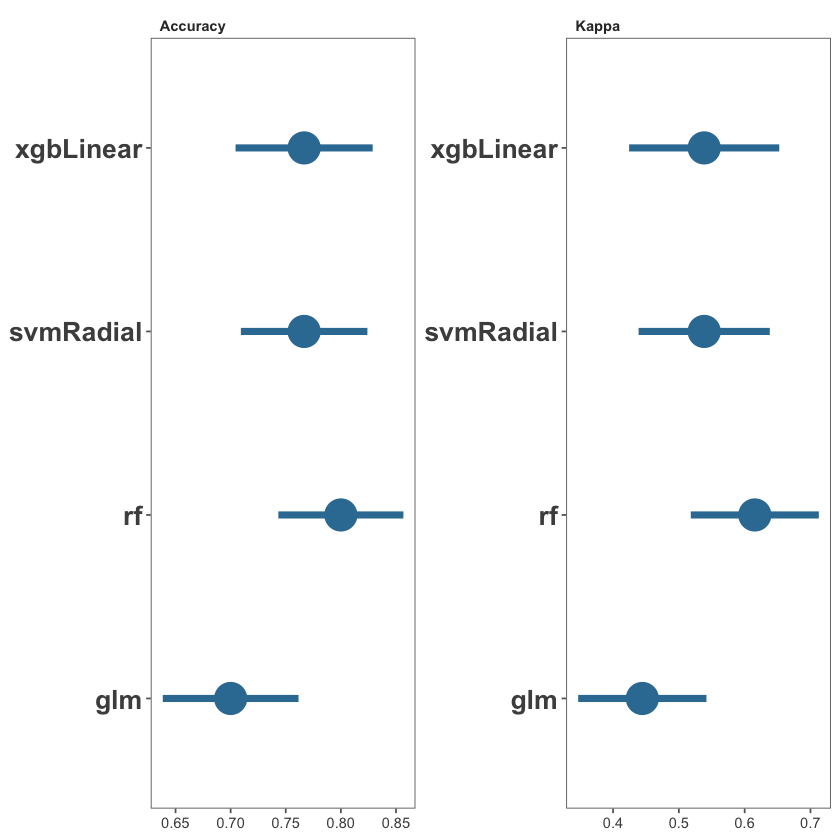

In [210]:
performance_plot(model_list, type = "dot", 
                 dpi = 300, file_name = "covid_performance", 
                 file_type = "png", save = TRUE, palette = "mako", 
                 text_size = 20, plot_height = 5)

## 5.2 ROC plots


Testing svmRadial...



Testing rf...



Testing glm...



Testing xgbLinear...



Done!

Setting levels: control = Non.Severe, case = Severe

Setting direction: controls > cases

Setting levels: control = Non.Severe, case = Severe

Setting direction: controls > cases

Setting levels: control = Non.Severe, case = Severe

Setting direction: controls > cases

Setting levels: control = Non.Severe, case = Severe

Setting direction: controls > cases

Warning message in rbind(svmRadial = c(100, 100, 100, 88.8888888888889, 88.8888888888889, :
“number of columns of result is not a multiple of vector length (arg 4)”
Warning message in rbind(svmRadial = c(0, 12.5, 25, 25, 37.5, 50, 62.5, 75, 87.5, :
“number of columns of result is not a multiple of vector length (arg 4)”


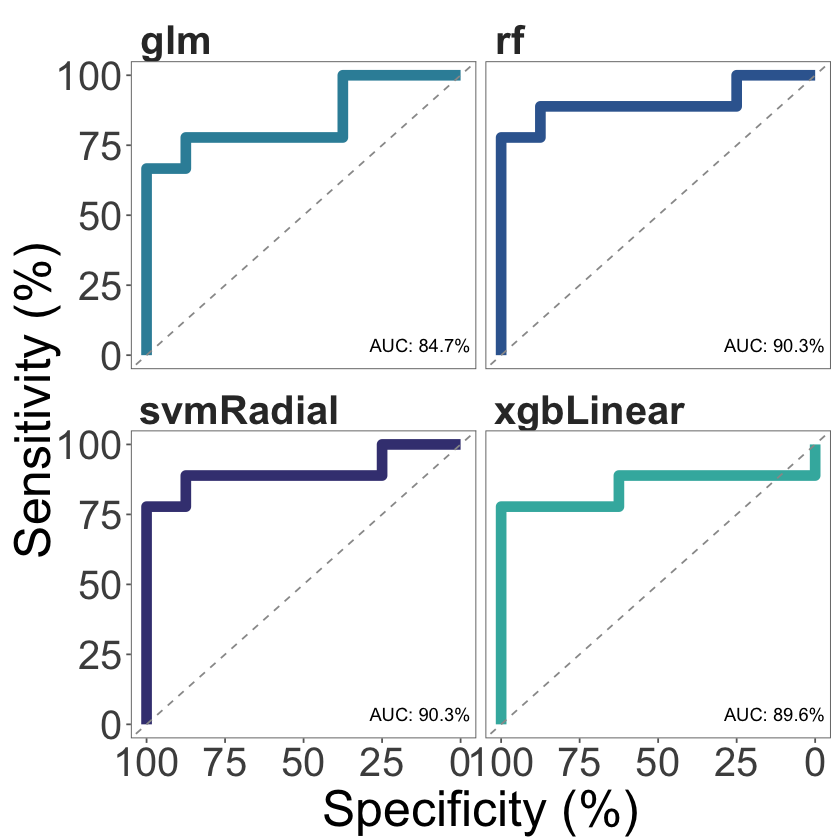

In [211]:
#Test the models on the test data
prob_list <- test_models(model_list = model_list, split_df = split_df3)

#Make ROC curves
roc_plot(probability_list = prob_list, split_df = split_df3,
         save = TRUE, file_name = "covid_roc", file_type = "png", 
         dpi = 300, palette = "mako", 
         plot_height = 14, plot_width = 14, text_size = 30)